In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_selection import SelectKBest, chi2

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Download for lemmatizer

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\EndUser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\EndUser\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\EndUser\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [29]:
# Load the dataset
df = pd.read_csv('Mental-Health-Twitter.csv')
print(df)

       Unnamed: 0             post_id                    post_created  \
0               0  637894677824413696  Sun Aug 30 07:48:37 +0000 2015   
1               1  637890384576778240  Sun Aug 30 07:31:33 +0000 2015   
2               2  637749345908051968  Sat Aug 29 22:11:07 +0000 2015   
3               3  637696421077123073  Sat Aug 29 18:40:49 +0000 2015   
4               4  637696327485366272  Sat Aug 29 18:40:26 +0000 2015   
...           ...                 ...                             ...   
19995       19995  819336825231773698  Thu Jan 12 00:14:56 +0000 2017   
19996       19996  819334654260080640  Thu Jan 12 00:06:18 +0000 2017   
19997       19997  819334503042871297  Thu Jan 12 00:05:42 +0000 2017   
19998       19998  819334419374899200  Thu Jan 12 00:05:22 +0000 2017   
19999       19999  819334270825197568  Thu Jan 12 00:04:47 +0000 2017   

                                               post_text     user_id  \
0      It's just over 2 years since I was diagnosed

In [30]:
df.shape

(20000, 11)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    20000 non-null  int64 
 1   post_id       20000 non-null  int64 
 2   post_created  20000 non-null  object
 3   post_text     20000 non-null  object
 4   user_id       20000 non-null  int64 
 5   followers     20000 non-null  int64 
 6   friends       20000 non-null  int64 
 7   favourites    20000 non-null  int64 
 8   statuses      20000 non-null  int64 
 9   retweets      20000 non-null  int64 
 10  label         20000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 1.7+ MB


In [32]:
df.describe()

,Unnamed: 0,post_id,user_id,followers,friends,favourites,statuses,retweets,label
count,20000.000000,2.000000e+04,2.000000e+04,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.000000
mean,9999.500000,6.874728e+17,3.548623e+16,900.483950,782.428750,6398.235550,4.439442e+04,1437.927300,0.500000
std,5773.647028,1.708396e+17,1.606083e+17,1899.913961,1834.817945,8393.072914,1.407785e+05,15119.665118,0.500013
min,0.000000,3.555966e+09,1.472438e+07,0.000000,0.000000,0.000000,3.000000e+00,0.000000,0.000000
25%,4999.750000,5.931686e+17,3.242944e+08,177.000000,211.000000,243.000000,5.129000e+03,0.000000,0.000000
50%,9999.500000,7.637400e+17,1.052122e+09,476.000000,561.000000,2752.000000,1.325100e+04,0.000000,0.500000
75%,14999.250000,8.153124e+17,2.285923e+09,1197.000000,701.000000,8229.000000,5.289200e+04,1.000000,1.000000
max,19999.000000,8.194574e+17,7.631825e+17,28614.000000,28514.000000,39008.000000,1.063601e+06,839540.000000,1.000000


In [33]:
df.isnull().sum()

Unnamed: 0      0
post_id         0
post_created    0
post_text       0
user_id         0
followers       0
friends         0
favourites      0
statuses        0
retweets        0
label           0
dtype: int64

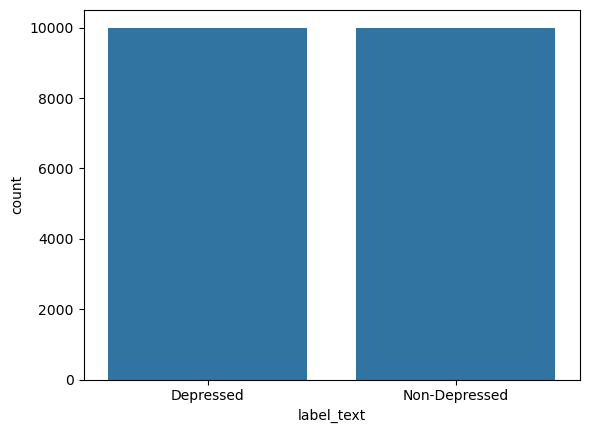

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map 0 and 1 to 'Non-Depressed' and 'Depressed'
df['label_text'] = df['label'].map({0: 'Non-Depressed', 1: 'Depressed'})

# Plot with the new column
sns.countplot(data=df, x="label_text")

# Display the plot
plt.show()

In [35]:
# Drop unnecessary columns
df.drop(["Unnamed: 0", "post_id", "user_id"], axis=1, inplace=True)

# Convert to datetime
df['post_created'] = pd.to_datetime(df['post_created'])
df['month'] = df['post_created'].dt.month
df['year'] = df['post_created'].dt.year
df.drop('post_created', axis=1, inplace=True)

C:\Users\EndUser\AppData\Local\Temp\ipykernel_19468\3198014151.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['post_created'] = pd.to_datetime(df['post_created'])


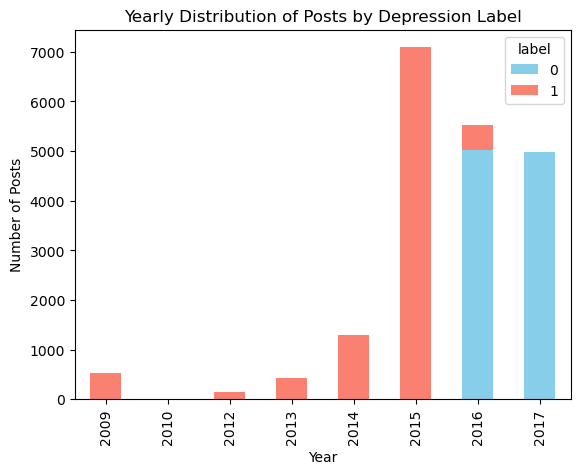

In [36]:
# Group by 'year' and 'label' to count the occurrences of each label per year
yearly_counts = df.groupby(['year', 'label']).size().unstack(fill_value=0)

# Plot the stacked bar chart
yearly_counts.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
plt.title('Yearly Distribution of Posts by Depression Label')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.show()

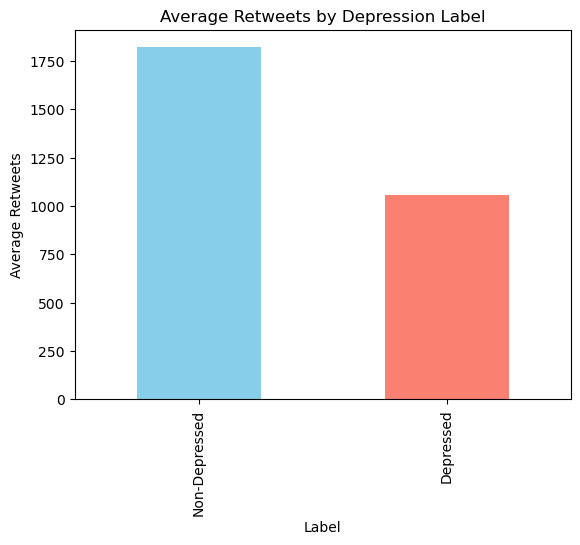

In [37]:
avg_retweets = df.groupby('label')['retweets'].mean()
avg_retweets.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Average Retweets by Depression Label')
plt.xlabel('Label')
plt.ylabel('Average Retweets')
plt.xticks([0, 1], ['Non-Depressed', 'Depressed'])
plt.show()

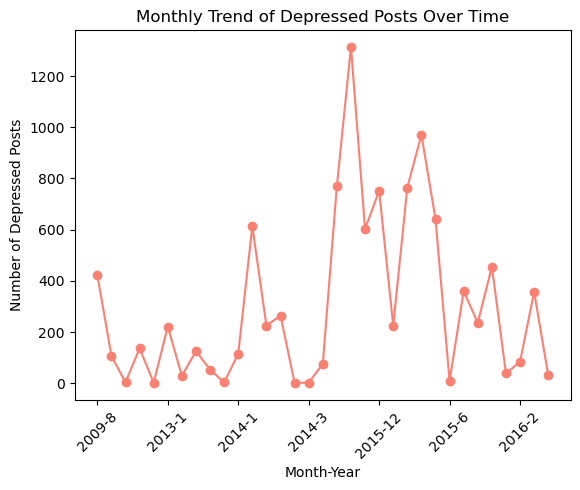

In [38]:
# Create a 'month_year' column combining year and month for grouping
df['month_year'] = df['year'].astype(str) + '-' + df['month'].astype(str)

# Filter the DataFrame for depressed posts (label == 1)
monthly_counts = df[df['label'] == 1].groupby('month_year').size()

# Plot the monthly trend
monthly_counts.plot(kind='line', color='salmon', marker='o')
plt.title('Monthly Trend of Depressed Posts Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Depressed Posts')
plt.xticks(rotation=45)
plt.show()

In [39]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Define stopwords
sw = stopwords.words("english")
custom_stopwords = set(sw) - {"great", "optimistic", "happy", "sad"}

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Text preprocessing function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove digits
    text = re.sub(r"\d+", "", text)
    # Remove punctuation except for '!'
    text = re.sub(r"[^\w\s!]", "", text)
    # Remove stopwords
    text = " ".join(word for word in text.split() if word not in custom_stopwords)
    # Lemmatize words
    text = " ".join(lemmatizer.lemmatize(word) for word in text.split())
    return text

# Apply preprocessing and store in a new column 'processed_text'
df['processed_text'] = df['post_text'].apply(preprocess_text)

# Check the new columns
df[['post_text', 'processed_text']].head()


,post_text,processed_text
0,It's just over 2 years since I was diagnosed w...,year since diagnosed anxiety depression today ...
1,"It's Sunday, I need a break, so I'm planning t...",sunday need break im planning spend little tim...
2,Awake but tired. I need to sleep but my brain ...,awake tired need sleep brain idea
3,RT @SewHQ: #Retro bears make perfect gifts and...,rt sewhq retro bear make perfect gift great be...
4,It’s hard to say whether packing lists are mak...,hard say whether packing list making life easi...


In [40]:
from textblob import TextBlob

# Function to calculate sentiment score
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis and store score in 'sentiment_score' column
df['sentiment_score'] = df['post_text'].apply(get_sentiment)

# Apply a threshold for sentiment classification in preprocessing
def sentiment_classification(text, sentiment_score):
    if sentiment_score > 0.2:  # Positive sentiment threshold
        return 'Not Depressed'
    return text  # Retain original text if not classified as 'Not Depressed'

# Update 'post_text' based on sentiment classification
df['post_text'] = df.apply(lambda row: sentiment_classification(row['post_text'], row['sentiment_score']), axis=1)

# Display first 5 rows with sentiment scores
print(df[['post_text', 'sentiment_score']].head(5))


                                           post_text  sentiment_score
0  It's just over 2 years since I was diagnosed w...         0.100000
1  It's Sunday, I need a break, so I'm planning t...        -0.093750
2  Awake but tired. I need to sleep but my brain ...        -0.262500
3                                      Not Depressed         1.000000
4  It’s hard to say whether packing lists are mak...        -0.045833


In [41]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(df['post_text'])

# Feature selection
selector = SelectKBest(chi2, k=500)  # Select top 500 features
X_kbest = selector.fit_transform(X, df['label'])

In [42]:
# Split data into training and test sets with selected features
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X_kbest, y, test_size=0.2, random_state=42)

In [43]:
# Train Decision Tree model
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)
y_pred_dt = decision_tree_model.predict(X_test)

Decision Tree Classification Report:
               precision    recall  f1-score   support

Not Depressed       0.74      0.60      0.67      1981
    Depressed       0.67      0.79      0.73      2019

     accuracy                           0.70      4000
    macro avg       0.71      0.70      0.70      4000
 weighted avg       0.71      0.70      0.70      4000



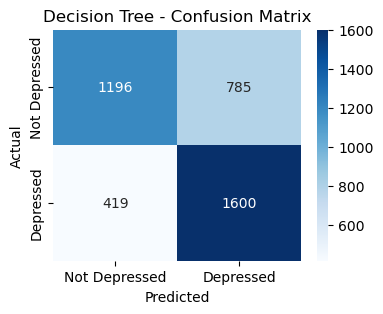

In [44]:
# Decision Tree Evaluation
accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)

# Confusion Matrix and Classification Report for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
print(f"Decision Tree Classification Report:\n{classification_report(y_test, y_pred_dt, target_names=['Not Depressed', 'Depressed'])}")

# Plot Confusion Matrix for Decision Tree
plt.figure(figsize=(4, 3))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.title('Decision Tree - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [45]:
# Train XGBoost model
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train, y_train)
y_pred_xgb = xgboost_model.predict(X_test)

XGBoost Classification Report:
               precision    recall  f1-score   support

Not Depressed       0.79      0.60      0.68      1981
    Depressed       0.68      0.85      0.76      2019

     accuracy                           0.72      4000
    macro avg       0.74      0.72      0.72      4000
 weighted avg       0.74      0.72      0.72      4000



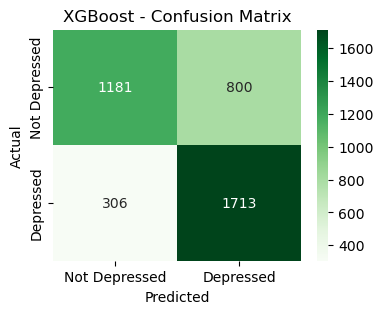

In [46]:
# XGBoost Evaluation
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)

# Confusion Matrix and Classification Report for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(f"XGBoost Classification Report:\n{classification_report(y_test, y_pred_xgb, target_names=['Not Depressed', 'Depressed'])}")

# Plot Confusion Matrix for XGBoost
plt.figure(figsize=(4, 3))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.title('XGBoost - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [47]:
# Train SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

SVM Classification Report:
               precision    recall  f1-score   support

Not Depressed       0.77      0.61      0.68      1981
    Depressed       0.68      0.82      0.74      2019

     accuracy                           0.72      4000
    macro avg       0.72      0.71      0.71      4000
 weighted avg       0.72      0.72      0.71      4000



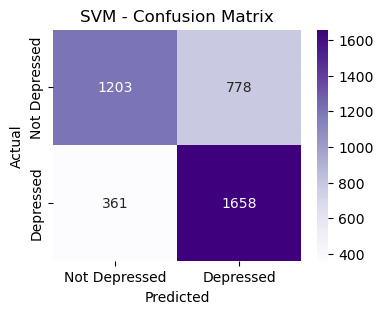

In [48]:
# SVM Evaluation
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)

# Confusion Matrix and Classification Report for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
print(f"SVM Classification Report:\n{classification_report(y_test, y_pred_svm, target_names=['Not Depressed', 'Depressed'])}")

# Plot Confusion Matrix for SVM
plt.figure(figsize=(4, 3))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.title('SVM - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [49]:
# Summary of model performances
print(f"\nPerformance Summary:")
print(f"Decision Tree - Accuracy: {accuracy_dt}, F1 Score: {f1_dt}, Precision: {precision_dt}, Recall: {recall_dt}")
print(f"XGBoost - Accuracy: {accuracy_xgb}, F1 Score: {f1_xgb}, Precision: {precision_xgb}, Recall: {recall_xgb}")
print(f"SVM - Accuracy: {accuracy_svm}, F1 Score: {f1_svm}, Precision: {precision_svm}, Recall: {recall_svm}")


Performance Summary:
Decision Tree - Accuracy: 0.699, F1 Score: 0.7266121707538601, Precision: 0.6708595387840671, Recall: 0.79247152055473
XGBoost - Accuracy: 0.7235, F1 Score: 0.7559576345984113, Precision: 0.6816553919617987, Recall: 0.8484398216939079
SVM - Accuracy: 0.71525, F1 Score: 0.7443322109988777, Precision: 0.680623973727422, Recall: 0.821198613174839


In [55]:
# Sentiment-aware prediction function
def predict_with_sentiment_filter(text, model):
    # Get sentiment score
    sentiment_score = get_sentiment(text)
    
    # Filter based on positive sentiment threshold
    if sentiment_score > 0.2:
        return 'Not Depressed'  # Early exit for clearly positive sentiment
    
    # Preprocess and vectorize the text
    processed_text = preprocess_text(text)
    if not processed_text:
        return "Unable to process text"
    
    vectorized_text = vectorizer.transform([processed_text])
    # Apply Chi-Square feature selection
    vectorized_text_kbest = selector.transform(vectorized_text)
    
    # Model prediction
    prediction = model.predict(vectorized_text_kbest)
    return 'Depressed' if prediction == 1 else 'Not Depressed'

# Example predictions with the best model
comments = [
    "Feeling very low and anxious lately. Can't seem to shake off the sadness.",
    "What a beautiful day! Feeling great and optimistic about everything.",
    "I've been struggling to focus and stay motivated these past few weeks.",
    "im so done with this life. im alone"
]

best_model = svm_model  # SVM is expected to be the best model based on evaluation
print(f"\nBest Model: XGBoost with Accuracy: {accuracy_xgb:.2f}")

for comment in comments:
    result = predict_with_sentiment_filter(comment, best_model)
    print(f"Comment: {comment}\nPrediction: {result}\n")



Best Model: XGBoost with Accuracy: 0.72
Comment: Feeling very low and anxious lately. Can't seem to shake off the sadness.
Prediction: Depressed

Comment: What a beautiful day! Feeling great and optimistic about everything.
Prediction: Not Depressed

Comment: I've been struggling to focus and stay motivated these past few weeks.
Prediction: Depressed

Comment: im so done with this life. im alone
Prediction: Depressed



In [51]:
df.to_csv('C:/Users/EndUser/RESEARCH/cleaned_dataset.csv', index=False)

In [57]:
import pickle

# Train XGBoost model
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train, y_train)

filename = 'depression_model.sav'
with open(filename, 'wb') as file:
    pickle.dump(xgboost_model, file)

#loading saved model
loaded_model=pickle.load(open('depression_model.sav', 'rb'))

In [58]:
import pickle

# Save the vectorizer to a .sav file
pickle.dump(vectorizer, open('C:/Users/EndUser/RESEARCH/vectorizer.sav', 'wb'))